In [20]:
import operator
from typing import Annotated, List, TypedDict, Union

from langchain.load.dump import dumps
from langchain_core.agents import AgentAction, AgentFinish


class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [2]:
ehi_information = """Title: EHI: End-to-end Learning of Hierarchical Index for
Efficient Dense Retrieval
Summary: Dense embedding-based retrieval is now the industry
standard for semantic search and ranking problems, like obtaining relevant web
documents for a given query. Such techniques use a two-stage process: (a)
contrastive learning to train a dual encoder to embed both the query and
documents and (b) approximate nearest neighbor search (ANNS) for finding similar
documents for a given query. These two stages are disjoint; the learned
embeddings might be ill-suited for the ANNS method and vice-versa, leading to
suboptimal performance. In this work, we propose End-to-end Hierarchical
Indexing -- EHI -- that jointly learns both the embeddings and the ANNS
structure to optimize retrieval performance. EHI uses a standard dual encoder
model for embedding queries and documents while learning an inverted file index
(IVF) style tree structure for efficient ANNS. To ensure stable and efficient
learning of discrete tree-based ANNS structure, EHI introduces the notion of
dense path embedding that captures the position of a query/document in the tree.
We demonstrate the effectiveness of EHI on several benchmarks, including
de-facto industry standard MS MARCO (Dev set and TREC DL19) datasets. For
example, with the same compute budget, EHI outperforms state-of-the-art (SOTA)
in by 0.6% (MRR@10) on MS MARCO dev set and by 4.2% (nDCG@10) on TREC DL19
benchmarks.
Author(s): Ramnath Kumar, Anshul Mittal, Nilesh Gupta, Aditya Kusupati,
Inderjit Dhillon, Prateek Jain
Source: https://arxiv.org/pdf/2310.08891.pdf"""

In [3]:
from langchain_core.tools import tool


@tool("search")
def search_tool(query: str):
    """Searches for information on the topic of artificial intelligence (AI).
    Cannot be used to research any other topics. Search query must be provided
    in natural language and be verbose."""
    # this is a "RAG" emulator
    return ehi_information


@tool("final_answer")
def final_answer_tool(answer: str, source: str):
    """Returns a natural language response to the user in `answer`, and a
    `source` which provides citations for where this information came from.
    """
    return ""

In [4]:
search_tool

StructuredTool(name='search', description='search(query: str) - Searches for information on the topic of artificial intelligence (AI).\n    Cannot be used to research any other topics. Search query must be provided\n    in natural language and be verbose.', args_schema=<class 'pydantic.v1.main.searchSchema'>, func=<function search_tool at 0x11722f920>)

In [5]:
import os

from langchain import hub
from langchain.agents import create_openai_tools_agent
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0)

prompt = hub.pull("hwchase17/openai-functions-agent")

query_agent_runnable = create_openai_tools_agent(
    llm=llm, tools=[final_answer_tool, search_tool], prompt=prompt
)

In [6]:
inputs = {"input": "what are EHI embeddings?", "intermediate_steps": []}
agent_out = query_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='search', tool_input={'query': 'EHI embeddings'}, log="\nInvoking: `search` with `{'query': 'EHI embeddings'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9Et3evKJA74bVDEdpxDtZHXH', 'function': {'arguments': '{"query":"EHI embeddings"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 150, 'total_tokens': 165}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3b956da36b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e037f71-d88b-4db9-bf36-0407f9c395ed-0', tool_calls=[{'name': 'search', 'args': {'query': 'EHI embeddings'}, 'id': 'call_9Et3evKJA74bVDEdpxDtZHXH'}])], tool_call_id='call_9Et3evKJA74bVDEdpxDtZHXH')]

In [7]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_9Et3evKJA74bVDEdpxDtZHXH',
 'function': {'arguments': '{"query":"EHI embeddings"}', 'name': 'search'},
 'type': 'function'}

In [8]:
import json

from langchain_core.agents import AgentFinish


def run_query_agent(state: list):
    print("> run_query_agent")
    agent_out = query_agent_runnable.invoke(state)
    return {"agent_out": agent_out}


def execute_search(state: list):
    print("> execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    out = search_tool.invoke(json.loads(tool_call["function"]["arguments"]))
    return {"intermediate_steps": [{"search": str(out)}]}


def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    return "error"


# finally, we will have a single LLM call that MUST use the final_answer structure
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")


# this forced final_answer LLM call will be used to structure output from our
# RAG endpoint
def rag_final_answer(state: list):
    print("> final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    context provided.

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}


# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our query_agent
def handle_error(state: list):
    print("> handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

In [23]:
query = "What is the EHI model?"
context = """Dense embedding-based retrieval is now the industry standard for semantic
search and ranking problems, like obtaining relevant web documents for a given
query. Such techniques use a two-stage process: (a) contrastive learning to
train a dual encoder to embed both the query and documents and (b) approximate
nearest neighbor search (ANNS) for finding similar documents for a given query.
These two stages are disjoint; the learned embeddings might be ill-suited for
the ANNS method and vice-versa, leading to suboptimal performance. In this
work, we propose End-to-end Hierarchical Indexing -- EHI -- that jointly learns
both the embeddings and the ANNS structure to optimize retrieval performance.
EHI uses a standard dual encoder model for embedding queries and documents while
learning an inverted file index (IVF) style tree structure for efficient ANNS.
"""

prompt = f"""You are a helpful assistant, answer the user's question using the
context provided.

CONTEXT: {context}

QUESTION: {query}
"""
out = final_answer_llm.invoke(prompt)
print(dumps(out, pretty=True))

{
  "lc": 1,
  "type": "constructor",
  "id": [
    "langchain",
    "schema",
    "messages",
    "AIMessage"
  ],
  "kwargs": {
    "content": "",
    "additional_kwargs": {
      "tool_calls": [
        {
          "id": "call_nwMvZqIi6voSbAN9AefbSzYy",
          "function": {
            "arguments": "{\"answer\":\"The EHI model, which stands for End-to-end Hierarchical Indexing, is a technique that jointly learns both the embeddings and the approximate nearest neighbor search (ANNS) structure to optimize retrieval performance. It uses a standard dual encoder model for embedding queries and documents while learning an inverted file index (IVF) style tree structure for efficient ANNS.\",\"source\":\"Research paper on dense embedding-based retrieval and End-to-end Hierarchical Indexing (EHI)\"}",
            "name": "final_answer"
          },
          "type": "function"
        }
      ]
    },
    "name": null,
    "id": "run-044b8737-31ba-4bc7-bc67-a10b8b9e8425-0",
    "tool_call

In [9]:
from langgraph.graph import StateGraph

graph = StateGraph(AgentState)

# we have four nodes that will consume our agent state and modify
# our agent state based on some internal process
graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

# our graph will always begin with the query agent
graph.set_entry_point("query_agent")

In [10]:
from langgraph.graph import END, StateGraph

graph = StateGraph(AgentState)

graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

graph.set_entry_point("query_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    start_key="query_agent",  # where in graph to start
    condition=router,  # function to determine which node is called
    conditional_edge_mapping={
        "search": "search",
        "error": "error",
        "final_answer": END,
    },
)
graph.add_edge("search", "rag_final_answer")
graph.add_edge("error", END)
graph.add_edge("rag_final_answer", END)

runnable = graph.compile()

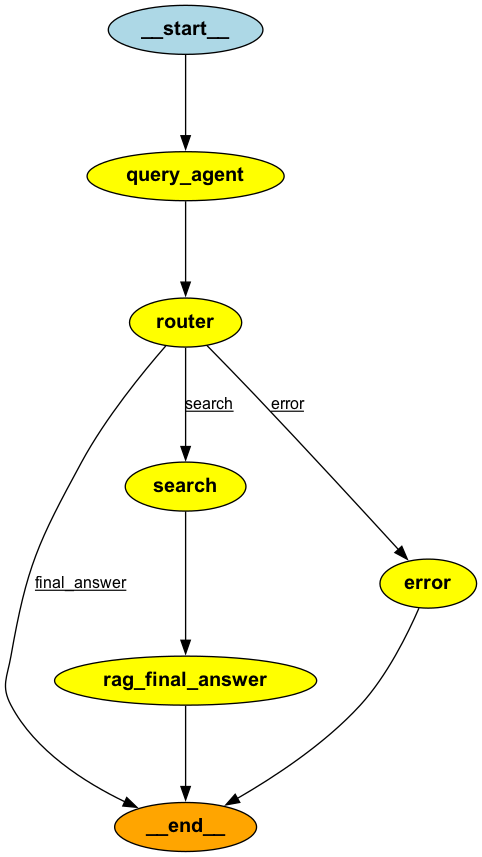

In [11]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [12]:
runnable = graph.compile()

out = runnable.invoke({"input": "what is AI?", "chat_history": []})

> run_query_agent
> router
> execute_search
> final_answer


In [13]:
print(out["agent_out"])

{"answer":"AI stands for Artificial Intelligence, which refers to the simulation of human intelligence processes by machines, especially computer systems. It involves the development of algorithms and models that enable machines to perform tasks that typically require human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making.","source":"https://en.wikipedia.org/wiki/Artificial_intelligence"}


In [14]:
out = runnable.invoke({"input": "what are EHI embeddings?", "chat_history": []})
print(out["agent_out"])

> run_query_agent
> router
> execute_search
> final_answer
{"answer":"EHI embeddings refer to the embeddings generated by the End-to-end Hierarchical Indexing (EHI) model. These embeddings are produced by a standard dual encoder model for queries and documents, while also learning an inverted file index (IVF) style tree structure for efficient approximate nearest neighbor search (ANNS). EHI introduces the concept of dense path embedding to capture the position of a query/document in the tree, ensuring stable and efficient learning of the discrete tree-based ANNS structure.","source":"https://arxiv.org/pdf/2310.08891.pdf"}


In [15]:
out = runnable.invoke(
    {"input": "can you tell me about EHI embeddings?", "chat_history": []}
)
print(out["agent_out"])

> run_query_agent
> router
> execute_search
> final_answer
{"answer":"EHI embeddings refer to the embeddings generated by the End-to-end Hierarchical Indexing (EHI) model. The EHI model jointly learns both the embeddings and the Approximate Nearest Neighbor Search (ANNS) structure to optimize retrieval performance. It uses a standard dual encoder model for embedding queries and documents while learning an inverted file index (IVF) style tree structure for efficient ANNS. EHI introduces the notion of dense path embedding to capture the position of a query/document in the tree, ensuring stable and efficient learning of the discrete tree-based ANNS structure.","source":"https://arxiv.org/pdf/2310.08891.pdf"}


In [16]:
out = runnable.invoke({"input": "hi", "chat_history": []})
print(out["agent_out"])

> run_query_agent
> router
> handle_error
{"answer":"Hello! How can I assist you today?","source":""}


In [17]:
out = runnable.invoke(
    {"input": "hi, please don't respond to me with a `source`", "chat_history": []}
)
print(out["agent_out"])

> run_query_agent
> router
> handle_error
{"answer":"Hello! How can I assist you today?","source":"N/A"}
